In [1]:
#hola the amigos
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import DataGenerator_3d
import time
import warnings

Using TensorFlow backend.


In [149]:
import pickle
#results = [train_preds, test_preds]
#pickle.dump(results,open('/home/ubuntu/data/code/chaining/test_data2.p','wb'))
results=pickle.load(open('/home/ubuntu/data/code/chaining/2dchain_preds_final_cipro.p','rb'))
train_preds = results[0]
test_preds = results[1]
print(len(test_preds), len(train_preds))



3158 12634


In [150]:
import Get_Simple_Fluctuations_Average_Intensity as simp

In [151]:
# finding fluc data
res_flucs_csv =  simp.flucs_from_csv('/home/ubuntu/data/resistant/')
sus_flucs_csv = simp.flucs_from_csv('/home/ubuntu/data/susceptible/')
#combine dictionaries
all_flucs = {**res_flucs_csv, **sus_flucs_csv} 

res_lengths = simp.getlengths('/home/ubuntu/data/resistant/')
sus_lengths = simp.getlengths('/home/ubuntu/data/susceptible/')
all_lengths = res_lengths+sus_lengths

In [152]:
# identifying labels
targets = simp.gettargets('/home/ubuntu/data/resistant/','/home/ubuntu/data/susceptible/')

In [153]:
# create new dictionary with paths and lengths
result_dict = {}
for path, length, _ in all_lengths:
    result_dict[path]=(length,all_flucs[path],targets[path])

In [154]:
import glue_code

In [155]:
#First find the cells in the train and test partitions
test_cells = sorted(glue_code.partition_to_keys(list(test_preds.keys())))
train_cells = sorted(glue_code.partition_to_keys(list(train_preds.keys())))

In [156]:
#go from list of cells, to list of lists of images from each cell
cell_ims_test = glue_code.split_preds_into_cells(test_preds,test_cells)
cell_ims_train = glue_code.split_preds_into_cells(train_preds,train_cells)

#get the av score for susceptible, and proportion of images classified as susceptible
cell_predictions_test = glue_code.get_cell_predictions(cell_ims_test,test_preds)
cell_predictions_train = glue_code.get_cell_predictions(cell_ims_train,train_preds)

#glue together CNN predictions and fluctuation/av/lengths/labels
test_final = glue_code.glue_flucs_preds(cell_predictions_test,result_dict)
train_final = glue_code.glue_flucs_preds(cell_predictions_train,result_dict)

In [157]:
#seperate res and sus with data in test_final
res_index = []
res_data = []
sus_index = []
sus_data = []
test_final = test_final+train_final
for name in ['/home/ubuntu/data/resistant']:
    b = []
    for glob_path in glob.glob(name+'/sample[0-9]*/cell[0-9]*'):
        b.append(glob_path)  
        
    for j in [path[0] for path in test_final]:
        for i in b:
            if i == j:
                res_index.append([path[0] for path in test_final].index(j)) 

for k in res_index:
    res_data.append(test_final[k])

c = np.arange(0,len(test_final))
sus_index = c[len(res_data):]

for l in sus_index:
    sus_data.append(test_final[l])

In [158]:
# seperate _data into individual lists

lengths_res = [data[3] for data in res_data]
flucs_res = [data[4] for data in res_data]
preds_res = [data[2] for data in res_data]

lengths_sus = [data[3] for data in sus_data]
flucs_sus = [data[4] for data in sus_data]
preds_sus = [data[2] for data in sus_data]

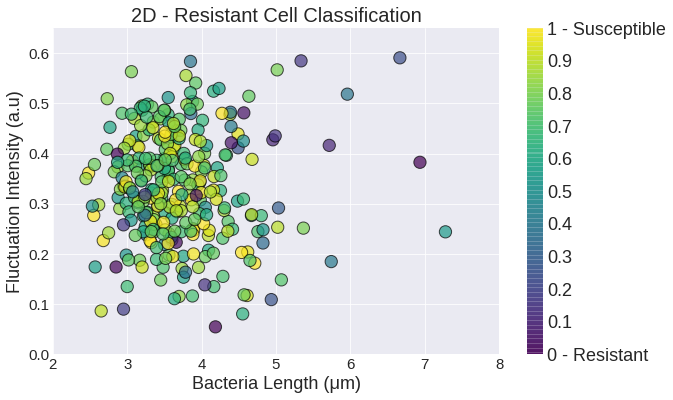

In [162]:
#plotting resistant
plt.style.use('seaborn-darkgrid')

x = lengths_res
y = flucs_res
z = preds_res

fig = plt.figure(figsize=(10,6))
plt.scatter(x,y,linewidths=1,alpha=.7,edgecolor='k',s = 150,c=z,cmap='viridis')

cb = plt.colorbar(ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
#cb.set_label(label='Model Classification', fontsize=20)
cb.set_ticklabels(['0 - Resistant','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1 - Susceptible'])
cb.ax.tick_params(labelsize=18)
plt.clim(0,1)

plt.title('2D - Resistant Cell Classification', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.ylim(0.,0.65)
plt.xlim(2,8)
plt.xlabel('Bacteria Length (μm)',fontsize=18)
plt.ylabel('Fluctuation Intensity (a.u)',fontsize=18)
#plt.savefig('/home/ubuntu/data/figures/sp/sp_cipro2d_res.png',dpi=500)

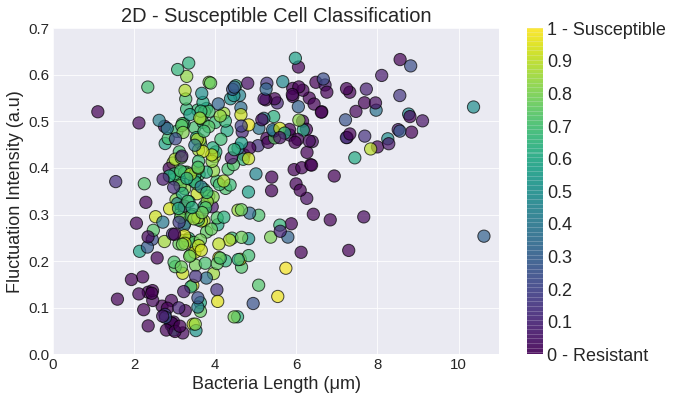

In [161]:
#plotting susceptible
plt.style.use('seaborn-darkgrid')
x = lengths_sus
y = flucs_sus
z = preds_sus

fig = plt.figure(figsize=(10,6))
plt.scatter(x,y,linewidths=1,alpha=.7,edgecolor='k',s = 150,c=z,cmap='viridis')

cb = plt.colorbar(ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
#cb.set_label(label='Model Classification', fontsize=20)
cb.set_ticklabels(['0 - Resistant','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1 - Susceptible'])
cb.ax.tick_params(labelsize=18)
plt.clim(0,1)

plt.title('2D - Susceptible Cell Classification', fontsize=20)
plt.xticks(fontsize=15, rotation=0)
plt.ylim(0,0.7)
plt.xlim(0,11)
plt.yticks(fontsize=15, rotation=0)
plt.xlabel('Bacteria Length (μm)',fontsize=18)
plt.ylabel('Fluctuation Intensity (a.u)',fontsize=18)
#plt.savefig('/home/ubuntu/data/figures/sp/sp_cipro2d_sus.png',dpi=500)